<a href="https://colab.research.google.com/github/kimhwijin/TensorflowWithKeras/blob/master/GAN/CycleGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [27]:
import tensorflow as tf
from tensorflow.keras import models, layers, optimizers
import tensorflow.keras.backend as K
from tensorflow.keras.losses import mean_squared_error, mean_absolute_error

import os
import matplotlib.pyplot as plt
import numpy as np
import tensorflow_datasets as tfds
import time

In [28]:
def normalize(input_image, label):
  input_image = tf.cast(input_image, tf.float32)
  input_image = input_image / 127.5 - 1
  return input_image


In [29]:
dataset, metadata = tfds.load('cycle_gan/summer2winter_yosemite', with_info=True, as_supervised=True)
train_A , train_B = dataset['trainA'] , dataset['trainB']
test_A , test_B = dataset['testA'], dataset['testB']

In [30]:
BUFFER_SIZE = 1000
BATCH_SIZE = 1
IMG_WIDTH = 256
IMG_HEIGHT = 256
EPOCHS = 50

In [31]:
#num_parallel_calls : 시스템의 CPU코어 여러개를 사용할수  있게끔한다.
#tf.data.experimental.AUTOTUNE : 텐서플로가 동적으로 최적의 숫자를 대신 결정한다.
#cache 변환은 데이터셋을 메모리 또는 로컬 저장소에 캐시할 수 있습니다. 이렇게하면 각 에포크 동안 실행되는 일부 작업(파일 열기 및 데이터 읽기 등)이 저장된다.
train_A = train_A.map(normalize, num_parallel_calls=tf.data.experimental.AUTOTUNE).cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
train_B = train_B.map(normalize, num_parallel_calls=tf.data.experimental.AUTOTUNE).cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
test_A = test_A.map(normalize, num_parallel_calls=tf.data.experimental.AUTOTUNE).cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
test_B = test_B.map(normalize, num_parallel_calls=tf.data.experimental.AUTOTUNE).cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [32]:
inpA = next(iter(train_A))
inpB = next(iter(train_B))

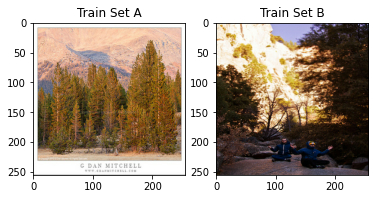

In [33]:
plt.subplot(121)
plt.title("Train Set A")
plt.imshow(inpA[0]*0.5 + 0.5)
plt.subplot(122)
plt.title("Train Set B")
plt.imshow(inpB[0]*0.5 + 0.5)

In [34]:
def downsample(filters, kernel_size=3, strides=2, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    initializer = tf.keras.initializers.random_normal(0.0, 0.02) #kernel matrix값 초기화방법
    result = tf.keras.Sequential()
    result.add(
      tf.keras.layers.Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, padding='same',
                             kernel_initializer=initializer, use_bias=False)) #왜 bias는 사용하지않을까?
    if apply_batchnorm:
        result.add(tf.keras.layers.BatchNormalization())
    result.add(tf.keras.layers.LeakyReLU())

    return result

def upsample(filters, kernel_size=3, strides=2, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    initializer = tf.keras.initializers.random_normal(0.0, 0.02)

    result = tf.keras.Sequential()
    result.add(
    tf.keras.layers.Conv2DTranspose(filters=filters, kernel_size=kernel_size, strides=strides,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False)) #왜 bias는 사용하지않을까?

    result.add(tf.keras.layers.BatchNormalization())

    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))

    result.add(tf.keras.layers.ReLU())

    return result

In [35]:
class ResnetIdentityBlock(tf.keras.Model): #tf.keras,models.Model 이랑 동일한듯.
  def __init__(self, kernel_size, filters):
    super(ResnetIdentityBlock, self).__init__(name='')
    filters1, filters2, filters3 = filters

    self.conv2a = tf.keras.layers.Conv2D(filters1, (1, 1))
    self.bn2a = tf.keras.layers.BatchNormalization()

    self.conv2b = tf.keras.layers.Conv2D(filters2, kernel_size, padding='same')
    self.bn2b = tf.keras.layers.BatchNormalization()

    self.conv2c = tf.keras.layers.Conv2D(filters3, (1, 1))
    self.bn2c = tf.keras.layers.BatchNormalization()

  def call(self, input_tensor, training=False):
    x = self.conv2a(input_tensor)
    x = self.bn2a(x, training=training)
    x = tf.nn.relu(x)

    x = self.conv2b(x)
    x = self.bn2b(x, training=training)
    x = tf.nn.relu(x)

    x = self.conv2c(x)
    x = self.bn2c(x, training=training)

    x += input_tensor
    return tf.nn.relu(x)

    
# (conv2d, b_n , relu * 3) or input_tensor // conv block 3번을 하거나, input_tensor을 그대로 내보내거나,
block1 = ResnetIdentityBlock(3, [512, 512, 512])
block2 = ResnetIdentityBlock(3, [512, 512, 512])
block3 = ResnetIdentityBlock(3, [512, 512, 512])


resnet = [block1, block2, block3]
print(block1(tf.zeros([1, 16, 16, 512])).shape)
print([x.name for x in block1.trainable_variables])

(1, 16, 16, 512)
['resnet_identity_block_3/conv2d_36/kernel:0', 'resnet_identity_block_3/conv2d_36/bias:0', 'resnet_identity_block_3/batch_normalization_39/gamma:0', 'resnet_identity_block_3/batch_normalization_39/beta:0', 'resnet_identity_block_3/conv2d_37/kernel:0', 'resnet_identity_block_3/conv2d_37/bias:0', 'resnet_identity_block_3/batch_normalization_40/gamma:0', 'resnet_identity_block_3/batch_normalization_40/beta:0', 'resnet_identity_block_3/conv2d_38/kernel:0', 'resnet_identity_block_3/conv2d_38/bias:0', 'resnet_identity_block_3/batch_normalization_41/gamma:0', 'resnet_identity_block_3/batch_normalization_41/beta:0']


In [36]:
#image를 받아서 재생성한 image를 출력한다. 
def build_generator():
    down_stack = [
        downsample(64, 4, apply_batchnorm=False),
        downsample(128, 4),
        downsample(256, 4), 
        downsample(512, 4) 
    ]

    up_stack = [
        upsample(256, 4),
        upsample(128, 4), 
        upsample(64, 4), 
    ]

    #마지막 레이어 tanh로 끝냄
    initializer = tf.random_normal_initializer(0., 0.02)
    last = tf.keras.layers.Conv2DTranspose(3, 4, strides=2, padding='same', kernel_initializer=initializer, activation='tanh') 


    #입력 레이어 image shape 이 256, 256 , 3 
    inputs = tf.keras.layers.Input(shape=[256, 256, 3])
    x = inputs

    #이미지 feature map 생성.
    skips = []
    for down in down_stack:
        #Covn2D , BatchNorm, LeakyReLU
        x = down(x)
        skips.append(x)
        
    #filters = 512인 conv2d 3개 resnet block이 3개 존재.
    for block in resnet:
        x = block(x)

    skips = reversed(skips[:-1])

    #downsample block 과 , upsample block 을 skip 연결한다.
    for up, skip in zip(up_stack, skips):
        concat = tf.keras.layers.Concatenate()
        x = up(x)
        x = concat([x, skip])

    #마지막 layer 추가
    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

In [37]:
generator = build_generator()

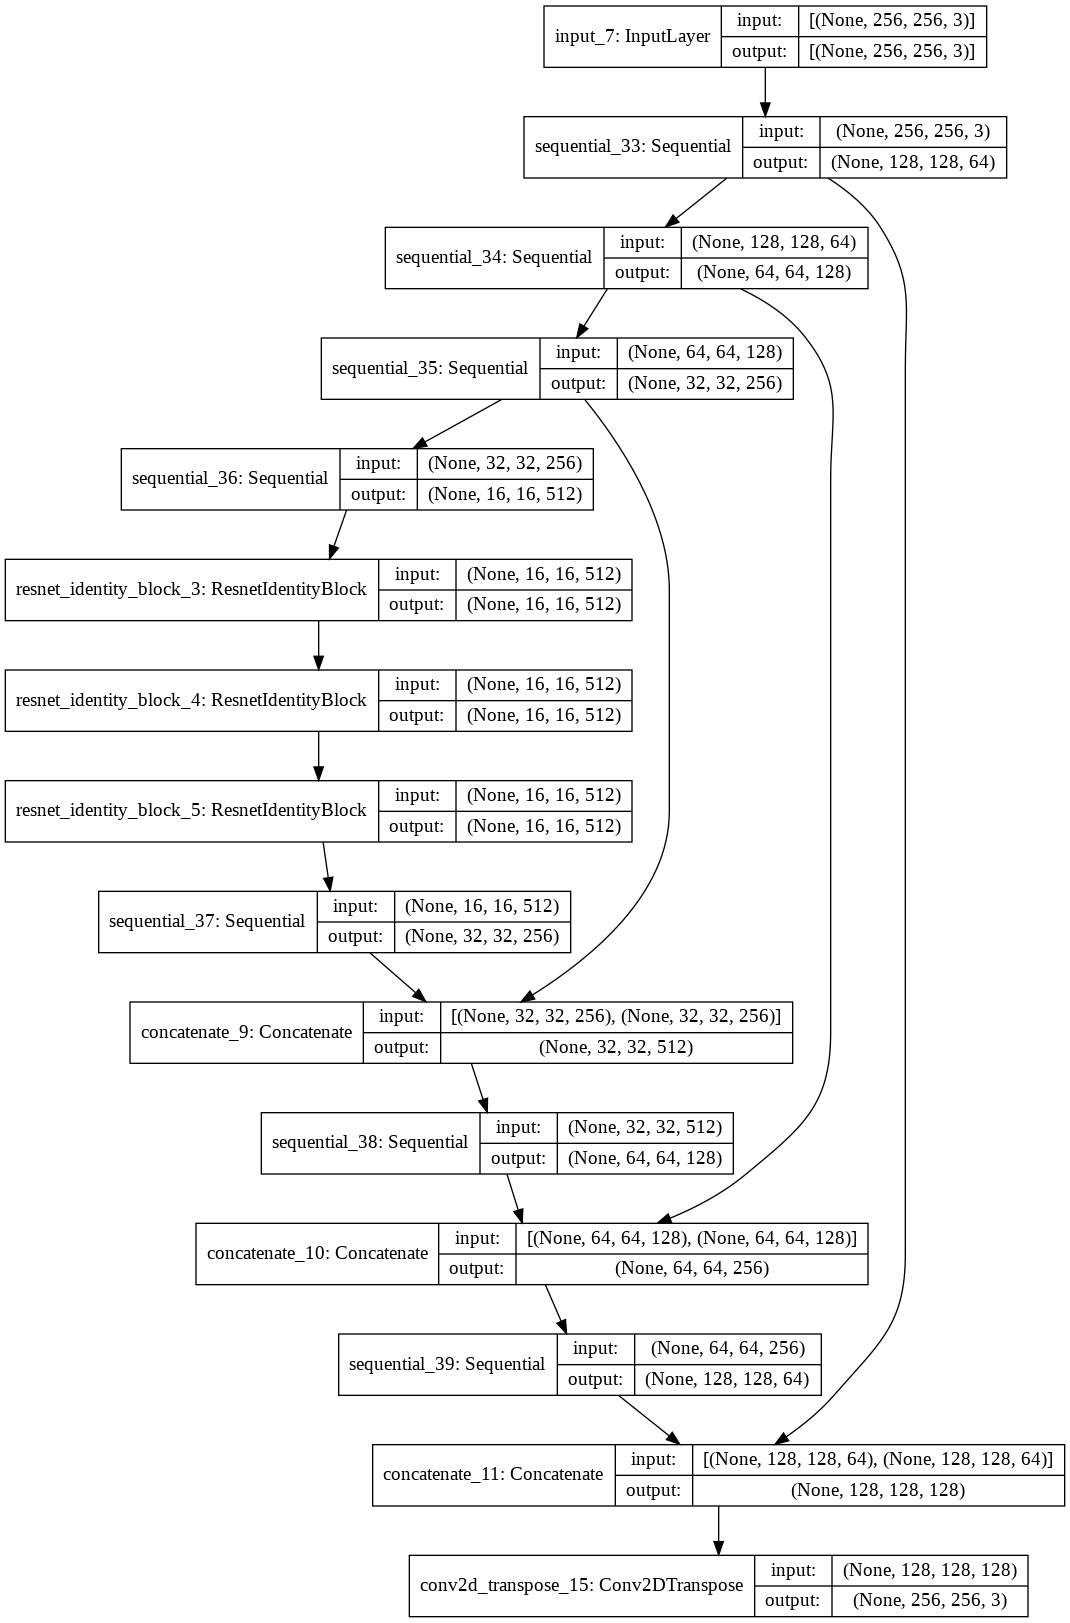

In [38]:
tf.keras.utils.plot_model(generator, 'drive/MyDrive/Colab Notebooks/models/cycle/generator.png', show_shapes=True)

In [39]:
generator.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
sequential_33 (Sequential)      (None, 128, 128, 64) 3072        input_7[0][0]                    
__________________________________________________________________________________________________
sequential_34 (Sequential)      (None, 64, 64, 128)  131584      sequential_33[0][0]              
__________________________________________________________________________________________________
sequential_35 (Sequential)      (None, 32, 32, 256)  525312      sequential_34[0][0]              
____________________________________________________________________________________________

(1, 256, 256, 3) 0.5283644 0.46270767


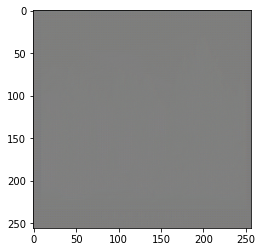

In [40]:
#훈련전 output 예시
gen_output = generator(inpA, training=False)
gen_output = (gen_output + 1) / 2 #0 ~ 1
plt.imshow(gen_output[0])
print(gen_output.shape,gen_output[0,...].numpy().max(), gen_output[0,...].numpy().min())

In [41]:
def build_discriminator():
    inputs = tf.keras.layers.Input(shape=[256,256,3])
    x = inputs

    #generator 의 첫번째 filter
    g_filter = 64

    down_stack = [#64 128 256 512
        downsample(g_filter), 
        downsample(g_filter * 2),
        downsample(g_filter * 4),
        downsample(g_filter * 8),
    ]
    

    for down in down_stack:
        x = down(x)

    #마지막도 conv
    last = tf.keras.layers.Conv2D(1, 4, strides=1, padding='same')
    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

In [42]:
discriminator = build_discriminator()
dis_output = discriminator(inpA, training=False)
print(dis_output.shape)

(1, 16, 16, 1)


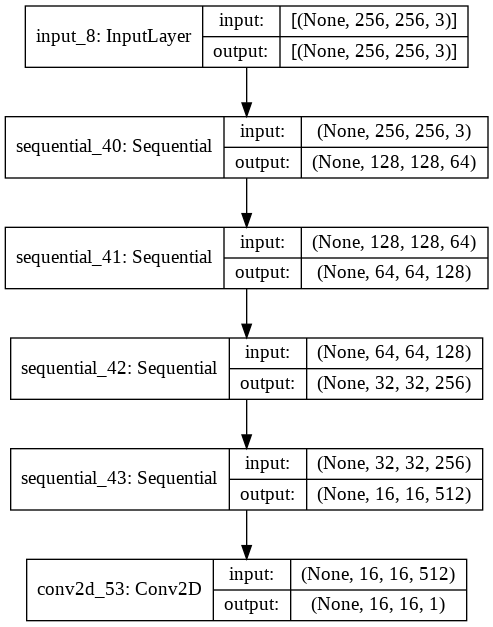

In [43]:
tf.keras.utils.plot_model(discriminator, 'drive/MyDrive/Colab Notebooks/models/cycle/discriminator.png', show_shapes=True)

In [44]:
discriminator.summary()

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
sequential_40 (Sequential)   (None, 128, 128, 64)      1984      
_________________________________________________________________
sequential_41 (Sequential)   (None, 64, 64, 128)       74240     
_________________________________________________________________
sequential_42 (Sequential)   (None, 32, 32, 256)       295936    
_________________________________________________________________
sequential_43 (Sequential)   (None, 16, 16, 512)       1181696   
_________________________________________________________________
conv2d_53 (Conv2D)           (None, 16, 16, 1)         8193      
Total params: 1,562,049
Trainable params: 1,560,129
Non-trainable params: 1,920
_____________________________________________

In [45]:
discriminator_A = build_discriminator()
discriminator_B = build_discriminator()

generator_AB = build_generator()
generator_BA = build_generator()

In [46]:
#from_logits : Whether y_pred is expected to be a logits tensor. By default, we assume that y_pred encodes a probability distribution.
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True) #y_pred가 logits 형태이면 logits? :https://opentutorials.org/module/3653/22995

In [47]:
#판별자 loss : crossentropy(1 - discriminator_real_output, discriminator_generated_output)
@tf.function
def discriminator_loss(disc_real_output, disc_generated_output):
  real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)
  gen_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)
  total_loss = real_loss + gen_loss
  return total_loss

In [48]:
optimizer = optimizers.Adam(0.0001, beta_1=0.5)
discriminator_optimzier = tf.keras.optimizers.Adam(0.0001, beta_1=0.5)

In [49]:
valid = np.ones((BATCH_SIZE, 16, 16, 1)).astype('float32') * 0.9
fake = np.ones((BATCH_SIZE, 16, 16, 1)).astype('float32') * 0.1

In [50]:
@tf.function
def train_batch(images_A, images_B):
  with tf.GradientTape() as g, tf.GradientTape() as d_tape:

    #입력 이미지를 FAKE 이미지 생성
    #G(X)
    fake_A = generator_AB(images_A, training=True)
    fake_B = generator_BA(images_B, training=True)

    #FAKE 이미지의 loss 계산 binary crossentropy
    logits_real_A = discriminator_A(images_A, training=True)
    logits_fake_A = discriminator_A(fake_A, training=True)
    dA_loss = discriminator_loss(logits_real_A, logits_fake_A)

    logits_real_B = discriminator_B(images_B, training=True)
    logits_fake_B = discriminator_B(fake_B, training=True)
    dB_loss = discriminator_loss(logits_real_B, logits_fake_B)

    d_loss = (dA_loss + dB_loss) / 2

    #FAKE 이미지를 REAL 이미지로 Reconstruct
    #F(G(X))
    reconstr_A = generator_BA(fake_B, training=True)
    reconstr_B = generator_AB(fake_A, training=True)

    #F(Y)
    id_A = generator_BA(images_A, training=True)
    id_B = generator_AB(images_B, training=True)

    gen_loss = tf.math.reduce_sum([
      #discriminator 의 결과와 valid 의 mse
      1 * tf.math.reduce_mean(mean_squared_error(logits_fake_A, valid)),
      1 * tf.math.reduce_mean(mean_squared_error(logits_fake_B, valid)),
      #F(G(X)) 와 X 의 mse
      10 * tf.math.reduce_mean(mean_squared_error(reconstr_A, images_A)),
      10 * tf.math.reduce_mean(mean_squared_error(reconstr_B, images_B)),
      #F(X) 와 X 의 차이: 이거는 변화시키는 부분을 제한시키기 위해서 즉 말 - 얼룩말 cycle에서 말을 제외한 부분은 놔두기위해?
      0.1 * tf.math.reduce_mean(mean_squared_error(id_A, images_A)),
      0.1 * tf.math.reduce_mean(mean_squared_error(id_B, images_B))
    ])
    

    #gradientTape.gradient( y , x ) => y를 x에 관해 미분한 값 : 기울기
    #위에서구한 기울기를 optimzier에 따라 변수에 적용시킨다. ex ) sgd , adam ....
    gradient_of_d = d_tape.gradient(d_loss, discriminator_A.trainable_variables + discriminator_B.trainable_variables)
    discriminator_optimzier.apply_gradients(zip(gradient_of_d ,discriminator_A.trainable_variables + discriminator_B.trainable_variables))
    
    gradient_of_g = g.gradient(gen_loss, generator_AB.trainable_variables + generator_BA.trainable_variables)
    optimizer.apply_gradients(zip(gradient_of_g, generator_AB.trainable_variables + generator_BA.trainable_variables))

    return dA_loss, dB_loss, gen_loss

In [51]:
checkpoint_dird_A = 'drive/MyDrive/Colab Notebooks/models/cycle/training_checkpointsd_A'
checkpoint_prefixd_A = os.path.join(checkpoint_dird_A, "ckpt_{epoch}")

checkpoint_dird_B = 'drive/MyDrive/Colab Notebooks/models/cycle/training_checkpointsd_B'
checkpoint_prefixd_B = os.path.join(checkpoint_dird_B, "ckpt_{epoch}")

checkpoint_dirg_AB = 'drive/MyDrive/Colab Notebooks/models/cycle/training_checkpointsg_AB'
checkpoint_prefixg_AB = os.path.join(checkpoint_dirg_AB, "ckpt_{epoch}")

checkpoint_dirg_BA = 'drive/MyDrive/Colab Notebooks/models/cycle/training_checkpointsg_BA'
checkpoint_prefixg_BA = os.path.join(checkpoint_dirg_BA, "ckpt_{epoch}")

In [52]:
def train(trainA_, trainB_, epochs):
    #dataset A, dataset B, epochs
    for epoch in range(epochs):
        start = time.time()
        
        #i 번째 batch, imageA(trainA), imageB(trainB)
        for batch_i, (imgs_A, imgs_B) in enumerate(zip(trainA_, trainB_)):
            #A인지 확인하는놈 loss, B인지 확인하는놈 loss, generator loss.
            dA_loss, dB_loss, g_loss = train_batch(imgs_A, imgs_B)
            
            #1000번 batch반복시마다, test 해본다.
            if batch_i % 1000 == 0:
                test_imgA = next(iter(test_A))
                test_imgB = next(iter(test_B))
                print ('Time taken for epoch {} batch index {} is {} seconds\n'.format(epoch, batch_i, time.time()-start))
                print("discriminator A: ", dA_loss.numpy())
                print("discriminator B: ", dB_loss.numpy())
                print("generator: {}\n".format(g_loss))

                fig, axs = plt.subplots(2, 2, figsize=(10, 10), sharey=True, sharex=True)
                gen_outputA = generator_AB(test_imgA, training=False)
                gen_outputB = generator_BA(test_imgB, training=False)
                axs[0,0].imshow(test_imgA[0]*0.5 + 0.5)
                axs[0,0].set_title("Generator A Input")
                axs[0,1].imshow(gen_outputA[0]*0.5 + 0.5)
                axs[0,1].set_title("Generator A Output")
                axs[1,0].imshow(test_imgB[0]*0.5 + 0.5)
                axs[1,0].set_title("Generator B Input")
                axs[1,1].imshow(gen_outputB[0]*0.5 + 0.5)
                axs[1,1].set_title("Generator B Output")
                plt.show()

                discriminator_A.save_weights(checkpoint_prefixd_A.format(epoch=epoch))
                discriminator_B.save_weights(checkpoint_prefixd_B.format(epoch=epoch))
                generator_AB.save_weights(checkpoint_prefixg_AB.format(epoch=epoch))
                generator_BA.save_weights(checkpoint_prefixg_BA.format(epoch=epoch))

Time taken for epoch 0 batch index 0 is 19.167362928390503 seconds

discriminator A:  1.5763936
discriminator B:  1.5894787
generator: 12.008828163146973



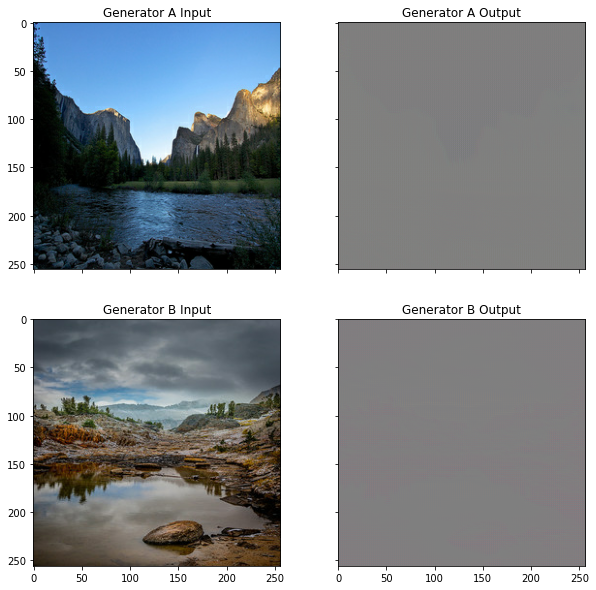

In [ ]:
train(train_A, train_B, EPOCHS)